https://www.kaggle.com/kumarajarshi/life-expectancy-who

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, mannwhitneyu 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from scipy.stats.mstats import winsorize
import missingno as msno
import pandas_profiling
from sqlalchemy import create_engine
import warnings
%matplotlib inline


warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

origin_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

In [3]:
origin_df.head(10)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,...,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,...,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,...,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,...,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,...,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1


In [4]:
origin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

# 1. Detect the problems with the data such as missing values and outliers. Are there any non- sense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regard- ing the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

## Missing values

In [5]:
origin_df.isnull().sum()*100/origin_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

Now we can see there are several columns which has missing values. We will fill in the missing values using interpolatin since our data is a time series data:

In [6]:
origin_df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')

In [7]:
df=origin_df.copy()

fill_list = ['Life expectancy ', 'Adult Mortality',
       'Alcohol', 'Hepatitis B',
       'Measles ', ' BMI ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling']

countries = df["Country"].unique()

for country in countries:
    df.loc[df["Country"] == country, fill_list] = df.loc[df["Country"] == country, fill_list].interpolate()
    
# we drop the null values after interpolation
df.dropna(inplace = True)

In [8]:
df.isnull().sum()*100/df.isnull().count()

Country                            0.0
Year                               0.0
Status                             0.0
Life expectancy                    0.0
Adult Mortality                    0.0
infant deaths                      0.0
Alcohol                            0.0
percentage expenditure             0.0
Hepatitis B                        0.0
Measles                            0.0
 BMI                               0.0
under-five deaths                  0.0
Polio                              0.0
Total expenditure                  0.0
Diphtheria                         0.0
 HIV/AIDS                          0.0
GDP                                0.0
Population                         0.0
 thinness  1-19 years              0.0
 thinness 5-9 years                0.0
Income composition of resources    0.0
Schooling                          0.0
dtype: float64

## Outliers

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1032d0210>,
      dtype=object)

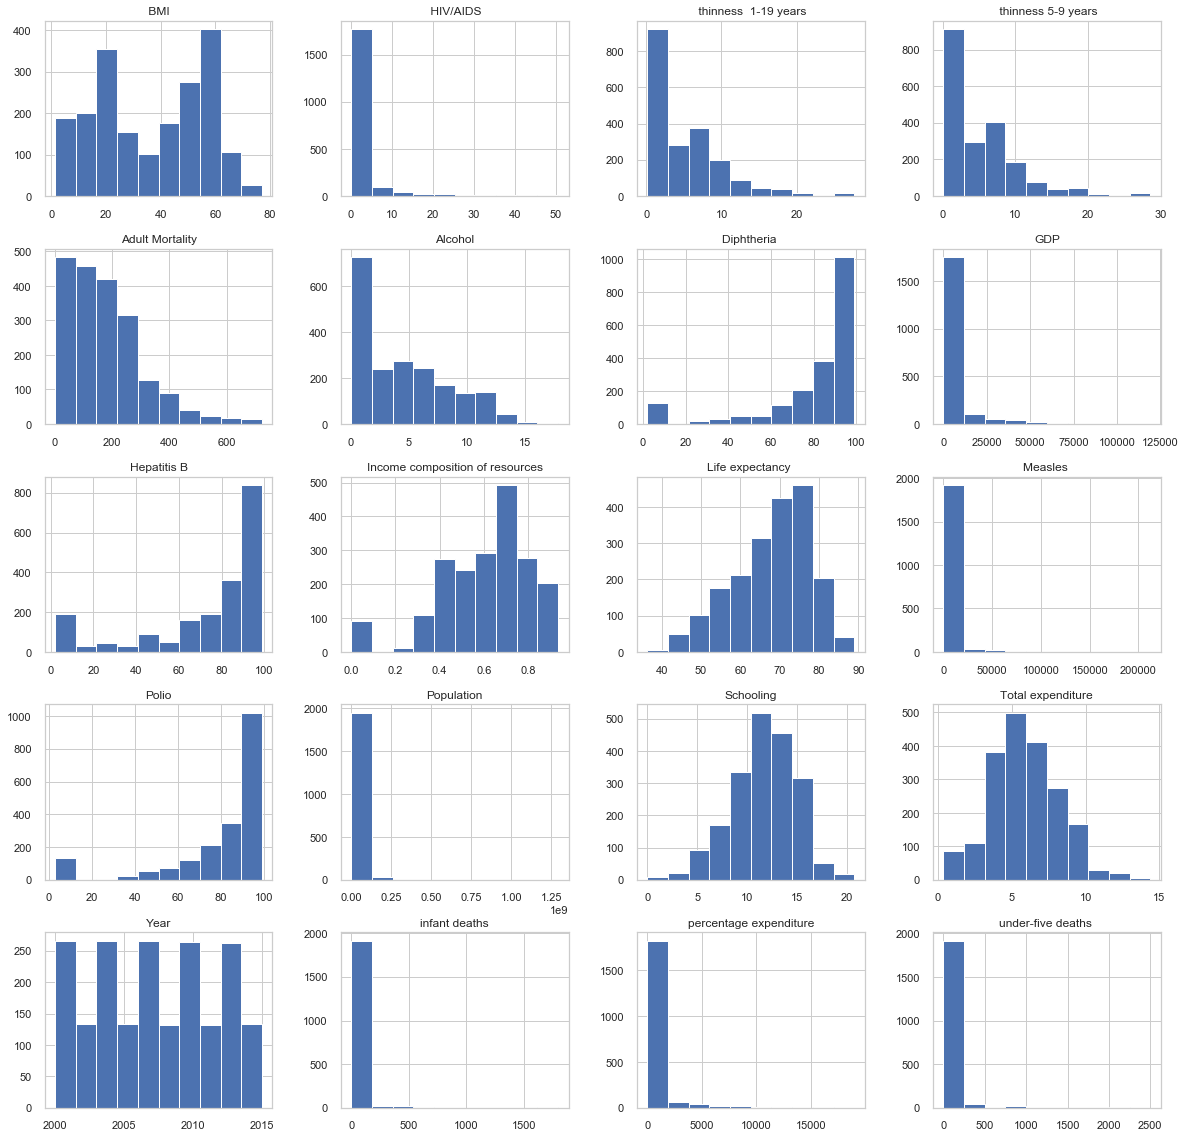

In [9]:
df.hist(figsize=(20,20))

Text(0.5, 1.0, 'under-five deaths ')

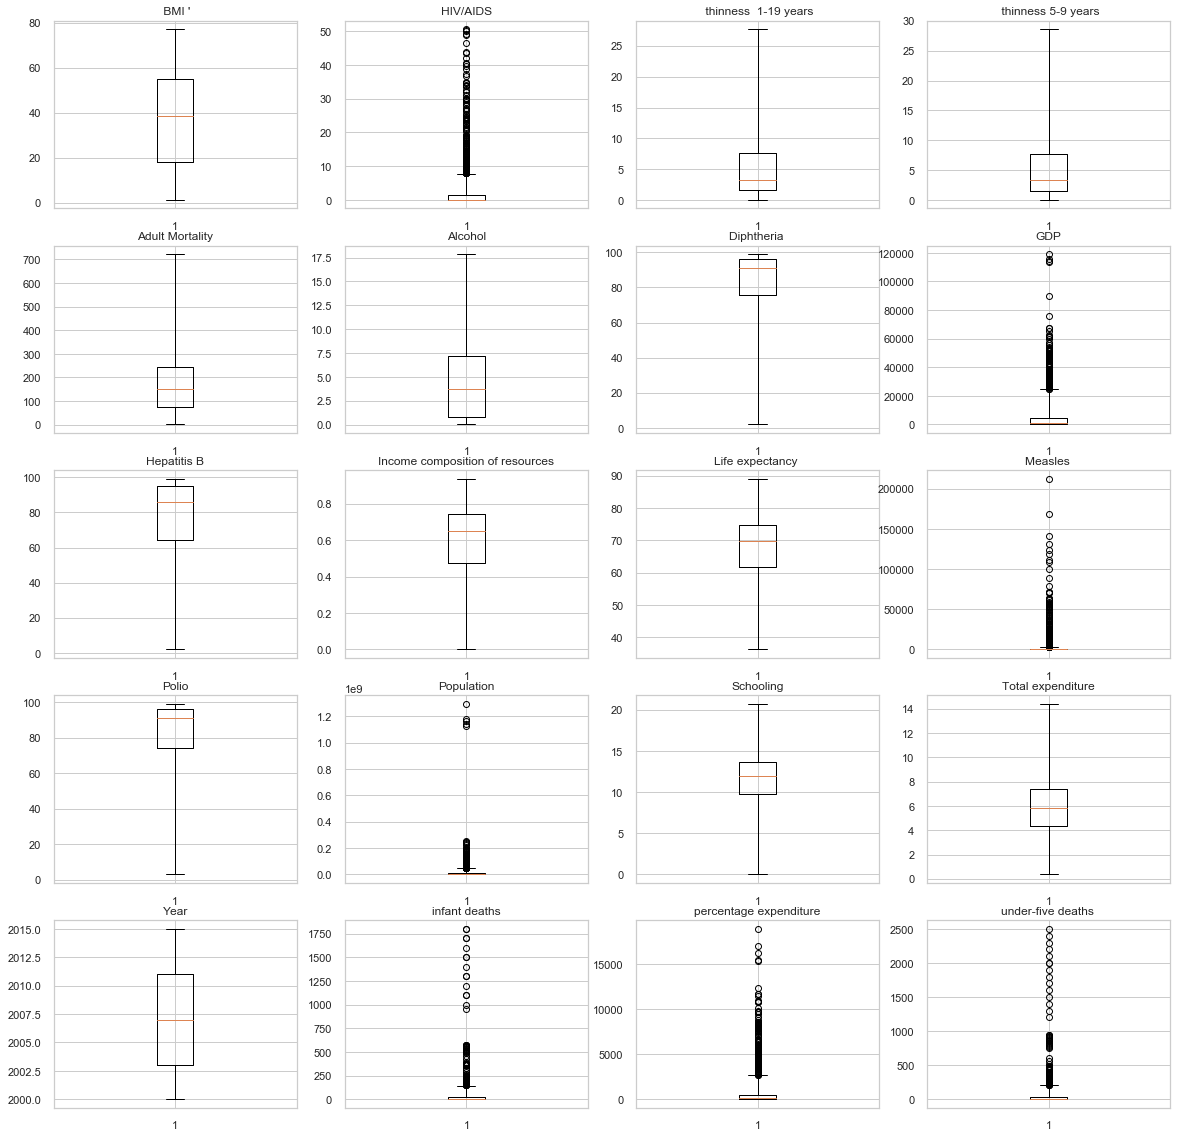

In [10]:
plt.figure(figsize = (20,20))

plt.subplot(5,4,1)
plt.boxplot(df[" BMI "], whis = 5)
plt.title(" BMI '")

plt.subplot(5,4,2)
plt.boxplot(df[" HIV/AIDS"], whis = 5)
plt.title("HIV/AIDS")

plt.subplot(5,4,3)
plt.boxplot(df[" thinness  1-19 years"], whis = 5)
plt.title(" thinness  1-19 years")

plt.subplot(5,4,4)
plt.boxplot(df[" thinness 5-9 years"], whis = 5)
plt.title(" thinness 5-9 years")

plt.subplot(5,4,5)
plt.boxplot(df["Adult Mortality"], whis = 5)
plt.title("Adult Mortality")

plt.subplot(5,4,6)
plt.boxplot(df["Alcohol"], whis = 5)
plt.title("Alcohol")

plt.subplot(5,4,7)
plt.boxplot(df["Diphtheria "], whis = 5)
plt.title("Diphtheria ")

plt.subplot(5,4,8)
plt.boxplot(df["GDP"], whis = 5)
plt.title("GDP")

plt.subplot(5,4,9)
plt.boxplot(df["Hepatitis B"], whis = 5)
plt.title("Hepatitis B")

plt.subplot(5,4,10)
plt.boxplot(df["Income composition of resources"], whis = 5)
plt.title("Income composition of resources")

plt.subplot(5,4,11)
plt.boxplot(df["Life expectancy "], whis = 5)
plt.title("Life expectancy ")

plt.subplot(5,4,12)
plt.boxplot(df["Measles "], whis = 5)
plt.title("Measles ")

plt.subplot(5,4,13)
plt.boxplot(df['Polio'], whis = 5)
plt.title('Polio')

plt.subplot(5,4,14)
plt.boxplot(df["Population"], whis = 5)
plt.title("Population")

plt.subplot(5,4,15)
plt.boxplot(df["Schooling"], whis = 5)
plt.title("Schooling")

plt.subplot(5,4,16)
plt.boxplot(df["Total expenditure"], whis = 5)
plt.title("Total expenditure")

plt.subplot(5,4,17)
plt.boxplot(df["Year"], whis = 5)
plt.title("Year")

plt.subplot(5,4,18)
plt.boxplot(df["infant deaths"], whis = 5)
plt.title("infant deaths")

plt.subplot(5,4,19)
plt.boxplot(df["percentage expenditure"], whis = 5)
plt.title("percentage expenditure")

plt.subplot(5,4,20)
plt.boxplot(df["under-five deaths "], whis = 5)
plt.title("under-five deaths ")

In [11]:
# create a dictionary of columns for make my work easier
col_dict = {'Life expectancy ':1, 'Adult Mortality':2,
       'infant deaths':3, 'Alcohol':4, 'percentage expenditure':5, 'Hepatitis B':6,
       'Measles ':7, ' BMI ':8, 'under-five deaths ':9, 'Polio':10, 'Total expenditure':11,
       'Diphtheria ':12, ' HIV/AIDS':13, 'GDP':14, 'Population':15,
       ' thinness  1-19 years':16, ' thinness 5-9 years':17,
       'Income composition of resources':18, 'Schooling':19}

# use Turkey's method
for variable in col_dict.keys():
    q75, q25 = np.percentile(df[variable], [75, 25])
    iqr = q75 - q25
    
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    print ("Number of outliers in {} : {}".format(variable, len((np.where((df[variable] > max_val) | (df[variable] < min_val))[0]))))

Number of outliers in Life expectancy  : 4
Number of outliers in Adult Mortality : 58
Number of outliers in infant deaths : 198
Number of outliers in Alcohol : 3
Number of outliers in percentage expenditure : 232
Number of outliers in Hepatitis B : 216
Number of outliers in Measles  : 361
Number of outliers in  BMI  : 0
Number of outliers in under-five deaths  : 227
Number of outliers in Polio : 159
Number of outliers in Total expenditure : 13
Number of outliers in Diphtheria  : 195
Number of outliers in  HIV/AIDS : 309
Number of outliers in GDP : 244
Number of outliers in Population : 260
Number of outliers in  thinness  1-19 years : 70
Number of outliers in  thinness 5-9 years : 75
Number of outliers in Income composition of resources : 91
Number of outliers in Schooling : 32


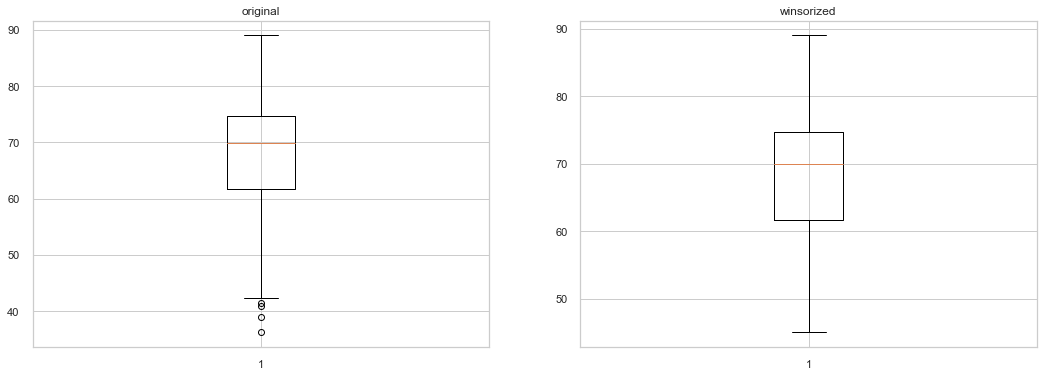

In [12]:
from scipy.stats.mstats import winsorize

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_life_expectancy = df["Life expectancy "]
plt.boxplot(original_life_expectancy)
plt.title("original")

plt.subplot(1,2,2)
winsorized_life_expectancy = winsorize(df["Life expectancy "], (0.01, 0))
plt.boxplot(winsorized_life_expectancy)
plt.title("winsorized")

plt.show()

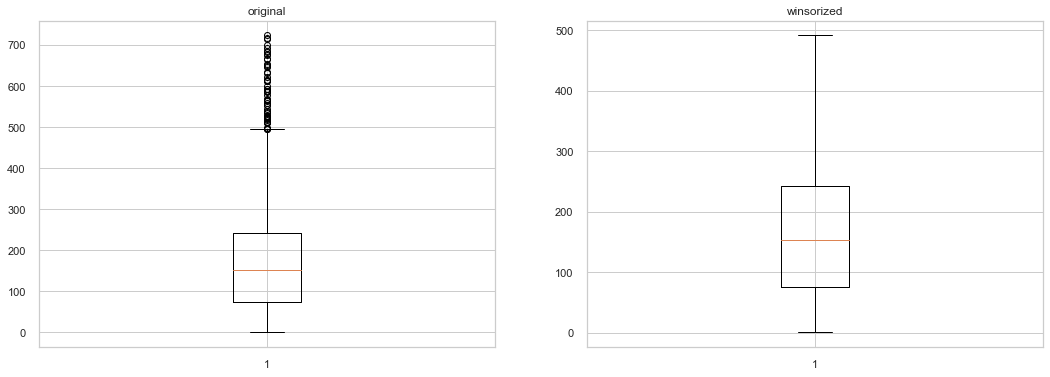

In [13]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_adult_mortality = df["Adult Mortality"]
plt.boxplot(original_adult_mortality)
plt.title("original")

plt.subplot(1,2,2)
winsorized_adult_mortality = winsorize(df["Adult Mortality"], (0, 0.03))
plt.boxplot(winsorized_adult_mortality)
plt.title("winsorized")

plt.show()

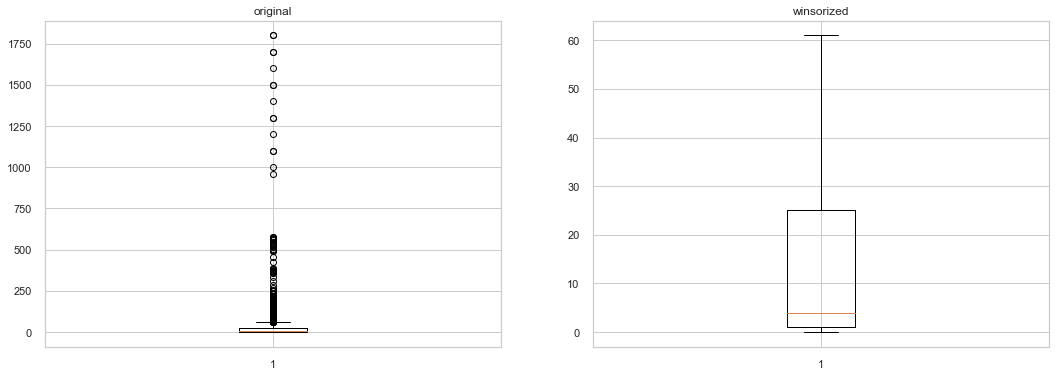

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_infant_death = df["infant deaths"]
plt.boxplot(original_infant_death)
plt.title("original")

plt.subplot(1,2,2)
winsorized_infant_death = winsorize(df["infant deaths"], (0, 0.1))
plt.boxplot(winsorized_infant_death)
plt.title("winsorized")

plt.show()

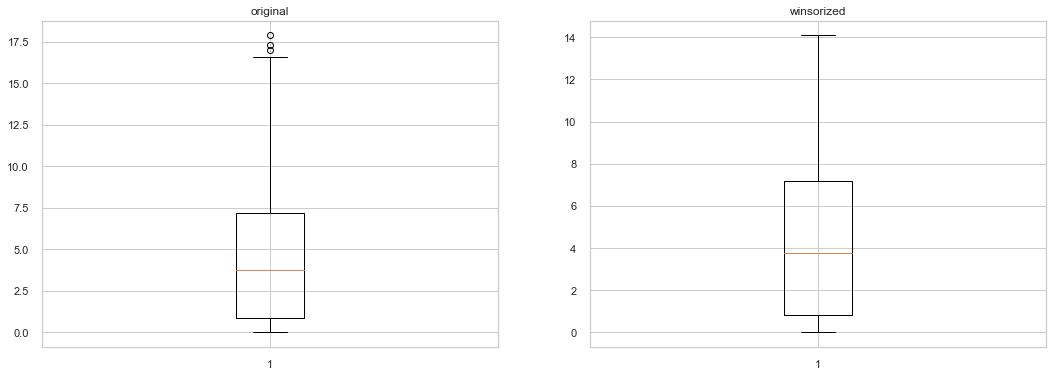

In [15]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_alcohol = df["Alcohol"]
plt.boxplot(original_alcohol)
plt.title("original")

plt.subplot(1,2,2)
winsorized_alcohol = winsorize(df["Alcohol"], (0, 0.01))
plt.boxplot(winsorized_alcohol)
plt.title("winsorized")

plt.show()

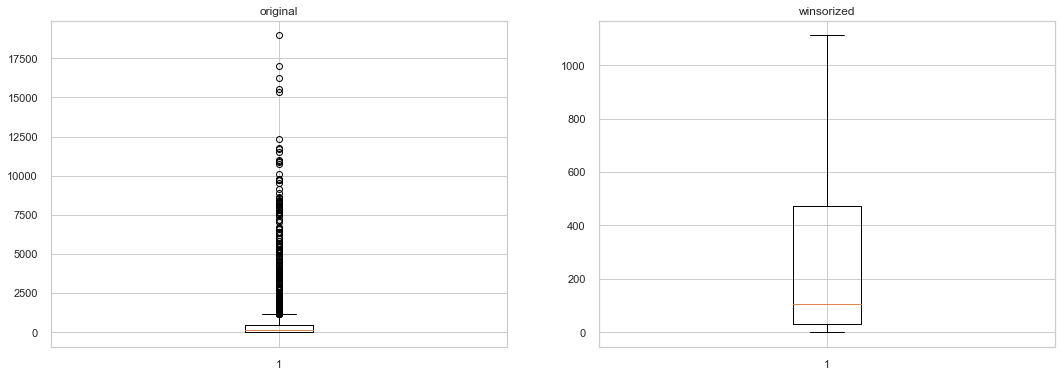

In [16]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_percentage_expenditure = df["percentage expenditure"]
plt.boxplot(original_percentage_expenditure)
plt.title("original")

plt.subplot(1,2,2)
winsorized_percentage_expenditure = winsorize(df["percentage expenditure"], (0, 0.12))
plt.boxplot(winsorized_percentage_expenditure)
plt.title("winsorized")

plt.show()

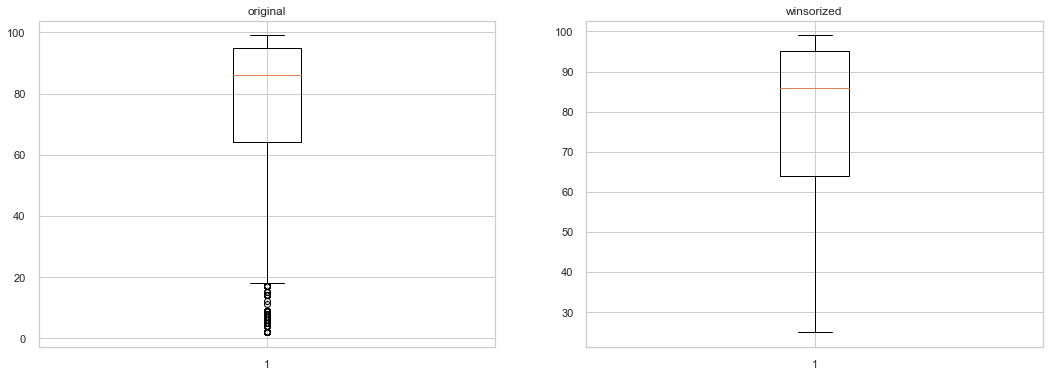

In [17]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_hepatitis = df["Hepatitis B"]
plt.boxplot(original_hepatitis)
plt.title("original")

plt.subplot(1,2,2)
winsorized_hepatitis = winsorize(df["Hepatitis B"], (0.12, 0))
plt.boxplot(winsorized_hepatitis)
plt.title("winsorized")

plt.show()

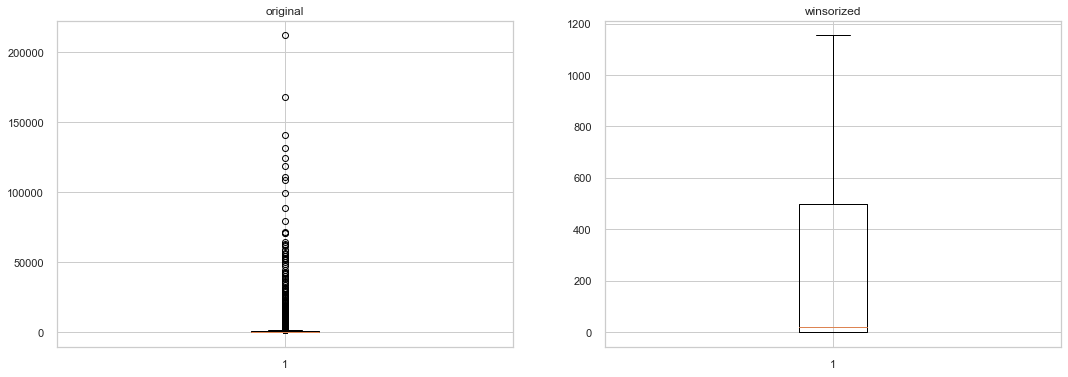

In [18]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_measles = df["Measles "]
plt.boxplot(original_measles)
plt.title("original")

plt.subplot(1,2,2)
winsorized_measles = winsorize(df["Measles "], (0, 0.19))
plt.boxplot(winsorized_measles)
plt.title("winsorized")

plt.show()

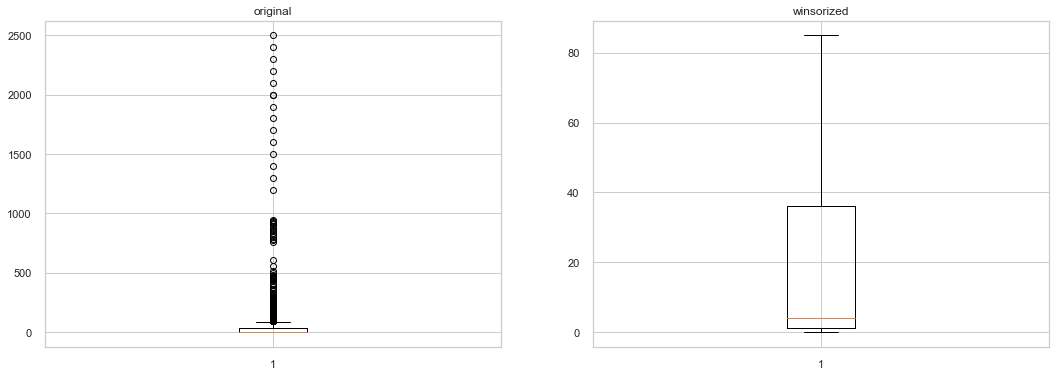

In [19]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_under5_death = df["under-five deaths "]
plt.boxplot(original_under5_death)
plt.title("original")

plt.subplot(1,2,2)
winsorized_under5_death = winsorize(df["under-five deaths "], (0, 0.12))
plt.boxplot(winsorized_under5_death)
plt.title("winsorized")

plt.show()

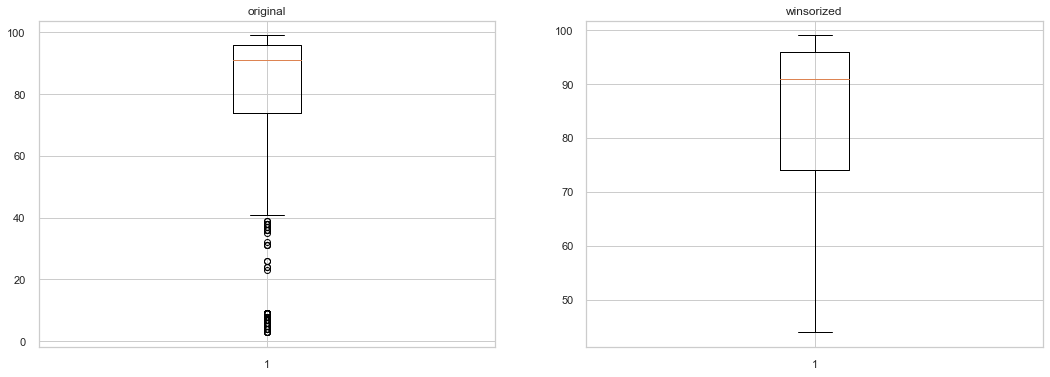

In [20]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_polio = df["Polio"]
plt.boxplot(original_polio)
plt.title("original")

plt.subplot(1,2,2)
winsorized_polio = winsorize(df["Polio"], (0.09, 0))
plt.boxplot(winsorized_polio)
plt.title("winsorized")

plt.show()

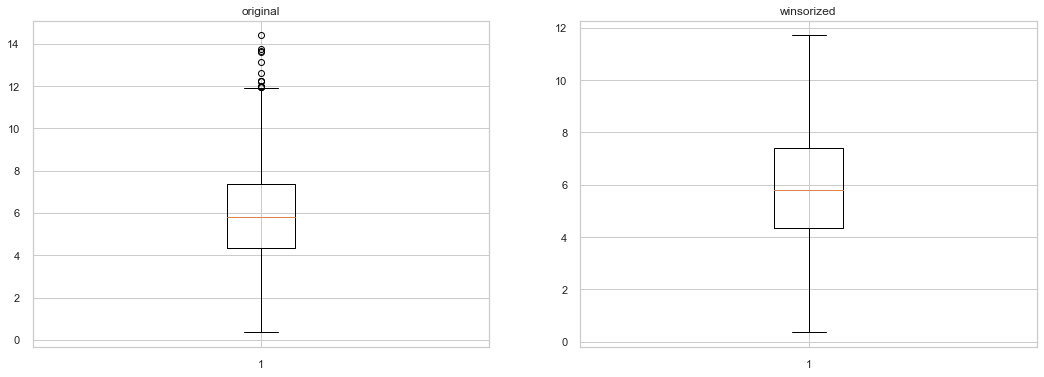

In [21]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_total_expenditure = df["Total expenditure"]
plt.boxplot(original_total_expenditure)
plt.title("original")

plt.subplot(1,2,2)
winsorized_total_expenditure = winsorize(df["Total expenditure"], (0, 0.01))
plt.boxplot(winsorized_total_expenditure)
plt.title("winsorized")

plt.show()

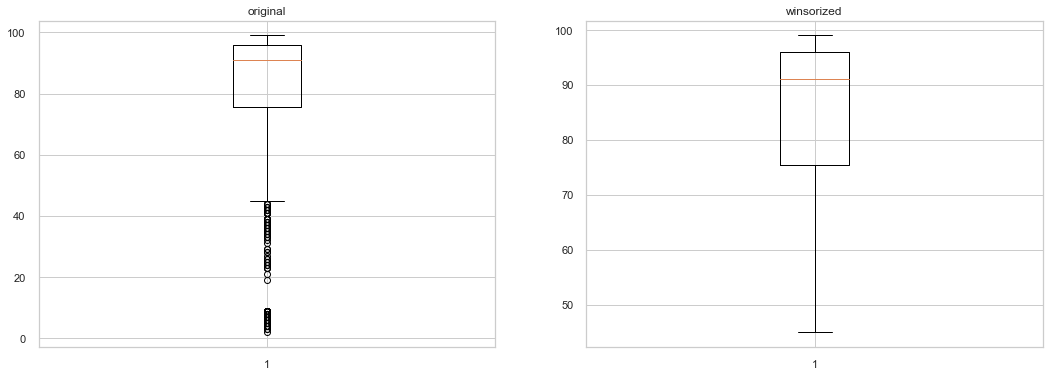

In [22]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_diphtheria = df["Diphtheria "]
plt.boxplot(original_diphtheria)
plt.title("original")

plt.subplot(1,2,2)
winsorized_diphtheria = winsorize(df["Diphtheria "], (0.1, 0))
plt.boxplot(winsorized_diphtheria)
plt.title("winsorized")

plt.show()

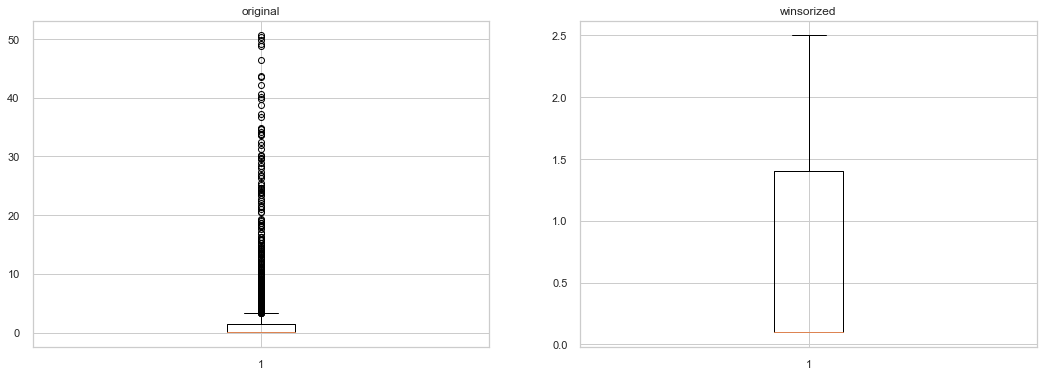

In [23]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_hiv = df[" HIV/AIDS"]
plt.boxplot(original_hiv)
plt.title("original")

plt.subplot(1,2,2)
winsorized_hiv = winsorize(df[" HIV/AIDS"], (0, 0.18))
plt.boxplot(winsorized_hiv)
plt.title("winsorized")

plt.show()

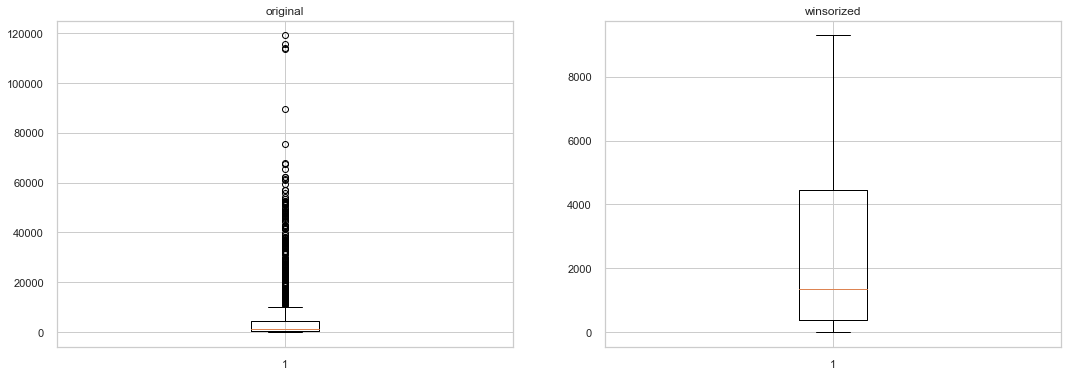

In [24]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_gdp = df["GDP"]
plt.boxplot(original_gdp)
plt.title("original")

plt.subplot(1,2,2)
winsorized_gdp = winsorize(df["GDP"], (0, 0.13))
plt.boxplot(winsorized_gdp)
plt.title("winsorized")

plt.show()

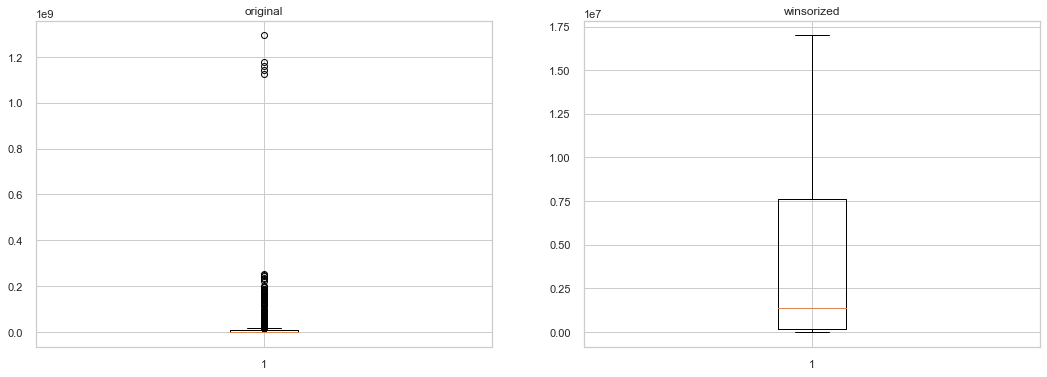

In [25]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_population = df["Population"]
plt.boxplot(original_population)
plt.title("original")

plt.subplot(1,2,2)
winsorized_population = winsorize(df["Population"], (0, 0.14))
plt.boxplot(winsorized_population)
plt.title("winsorized")

plt.show()

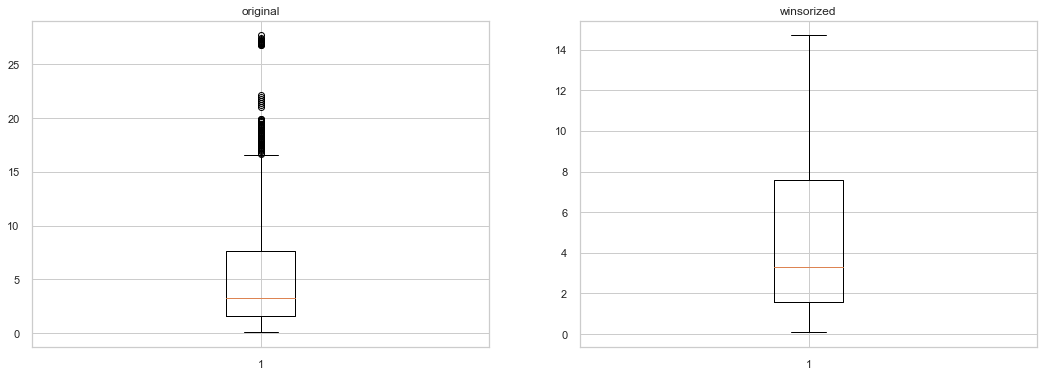

In [26]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_thinness_1_19 = df[" thinness  1-19 years"]
plt.boxplot(original_thinness_1_19)
plt.title("original")

plt.subplot(1,2,2)
winsorized_thinness_1_19 = winsorize(df[" thinness  1-19 years"], (0, 0.05))
plt.boxplot(winsorized_thinness_1_19)
plt.title("winsorized")

plt.show()

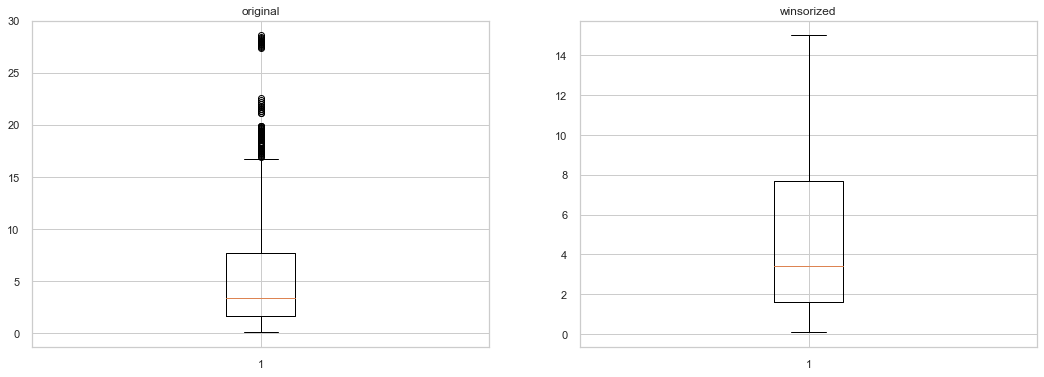

In [27]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_thinness_5_9 = df[" thinness 5-9 years"]
plt.boxplot(original_thinness_5_9)
plt.title("original")

plt.subplot(1,2,2)
winsorized_thinness_5_9 = winsorize(df[" thinness 5-9 years"], (0, 0.05))
plt.boxplot(winsorized_thinness_5_9)
plt.title("winsorized")

plt.show()

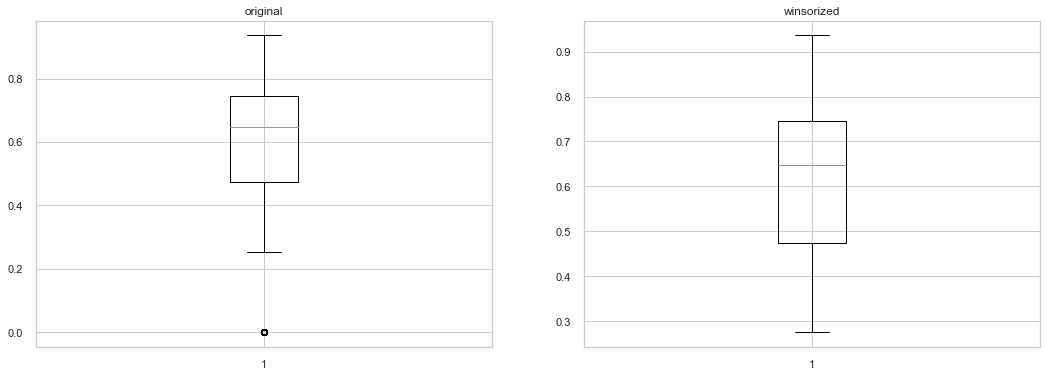

In [28]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_income = df["Income composition of resources"]
plt.boxplot(original_income)
plt.title("original")

plt.subplot(1,2,2)
winsorized_income = winsorize(df["Income composition of resources"], (0.05, 0))
plt.boxplot(winsorized_income)
plt.title("winsorized")

plt.show()

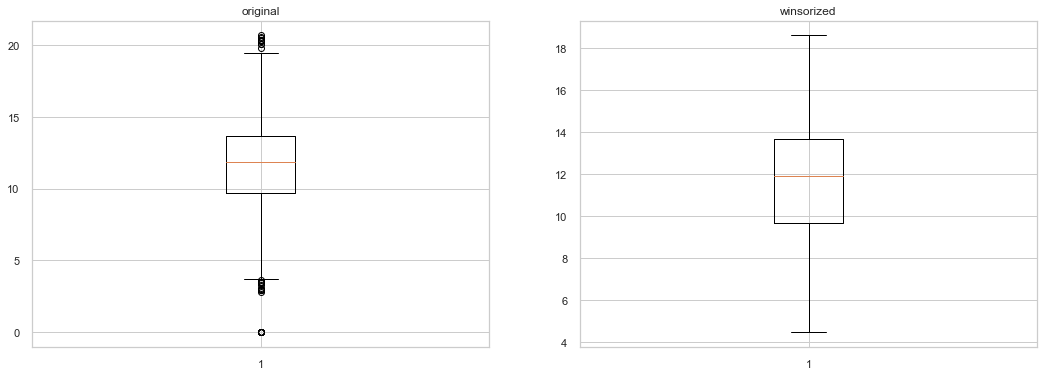

In [60]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
original_schooling = df["Schooling"]
plt.boxplot(original_schooling)
plt.title("original")

plt.subplot(1,2,2)
winsorized_schooling = winsorize(df["Schooling"], (0.02, 0.01))
plt.boxplot(winsorized_schooling)
plt.title("winsorized")

plt.show()

In [63]:
winsorized_list = [winsorized_life_expectancy, winsorized_adult_mortality, winsorized_infant_death, winsorized_alcohol, winsorized_percentage_expenditure,
                   winsorized_hepatitis, winsorized_measles, winsorized_under5_death, winsorized_polio, winsorized_total_expenditure, 
                   winsorized_diphtheria, winsorized_hiv, winsorized_gdp, winsorized_population, winsorized_thinness_1_19, winsorized_thinness_5_9,
                   winsorized_income, winsorized_schooling]

for variable in winsorized_list:
    q75, q25 = np.percentile(variable, [75, 25])
    iqr = q75 - q25
    
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print ("Number of outliers after winsorization : {}".format(len(np.where((variable > max_val) | (variable < min_val))[0])))

Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0
Number of outliers after winsorization : 0


In [64]:


df["winsorized_life_expectancy"] = winsorized_life_expectancy
df["winsorized_adult_mortality"] = winsorized_adult_mortality
df["winsorized_infant_death"] = winsorized_infant_death
df["winsorized_alcohol"] = winsorized_alcohol
df["winsorized_percentage_expenditure"] = winsorized_percentage_expenditure
df["winsorized_hepatitis"] = winsorized_hepatitis
df["winsorized_measles"] = winsorized_measles
df["winsorized_under5_death"] = winsorized_under5_death
df["winsorized_polio"] = winsorized_polio
df["winsorized_total_expenditure"] = winsorized_total_expenditure
df["winsorized_diphtheria"] = winsorized_diphtheria
df["winsorized_hiv"] = winsorized_hiv
df["winsorized_gdp"] = winsorized_gdp
df["winsorized_population"] = winsorized_population
df["winsorized_thinness_1_19"] = winsorized_thinness_1_19
df["winsorized_thinness_5_9"] = winsorized_thinness_5_9
df["winsorized_income"] = winsorized_income
df["winsorized_schooling"] = winsorized_schooling


# 2. Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [65]:
df.describe(include = "all")

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv,winsorized_gdp,winsorized_population,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income,winsorized_schooling
count,1987,1987.000000,1987,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1987.000000,...,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000,1987.000000,1987.000000,1987.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2006.984902,NaN,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2729.561651,...,82.957725,5.895471,83.225969,0.755159,2864.719760,4.799769e+06,4.909311,4.966885,0.616143,11.658581
std,NaN,4.323147,NaN,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,12102.389143,...,17.556131,2.266421,17.239348,0.957757,3186.069874,6.217060e+06,4.072985,4.120521,0.174584,3.102260
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,0.000000,...,44.000000,0.370000,45.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.276000,4.500000
25%,NaN,2003.000000,NaN,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,0.000000,...,74.000000,4.360000,75.500000,0.100000,384.553107,1.967480e+05,1.600000,1.600000,0.473000,9.700000
50%,NaN,2007.000000,NaN,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,20.000000,...,91.000000,5.800000,91.000000,0.100000,1334.651896,1.396861e+06,3.300000,3.400000,0.648000,11.900000
75%,NaN,2011.000000,NaN,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,499.500000,...,96.000000,7.385000,96.000000,1.400000,4441.530655,7.625918e+06,7.600000,7.700000,0.745000,13.700000


## Univariate Analysis

In [37]:
df.columns

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling',
       'winsorized_life_expectancy', 'winsorized_adult_mortality',
       'winsorized_infant_death', 'winsorized_alcohol',
       'winsorized_percentage_expenditure', 'winsorized_hepatitis',
       'winsorized_measles', 'winsorized_under5_death', 'winsorized_polio',
       'winsorized_total_expenditure', 'winsorized_diphtheria',
       'winsorized_hiv', 'winsorized_gdp', 'winsorized_population',
       'winsorized_thinness_1_19', 'winsorized_thinness_5_9',
       'winsorized_income', 'winsorized_schooling'],
      dtype='object')

In [68]:
features = [' BMI ','winsorized_life_expectancy', 'winsorized_adult_mortality',
       'winsorized_infant_death', 'winsorized_alcohol',
       'winsorized_percentage_expenditure', 'winsorized_hepatitis',
       'winsorized_measles', 'winsorized_under5_death', 'winsorized_polio',
       'winsorized_total_expenditure', 'winsorized_diphtheria',
       'winsorized_hiv', 'winsorized_gdp', 'winsorized_population',
       'winsorized_thinness_1_19', 'winsorized_thinness_5_9',
       'winsorized_income', 'winsorized_schooling']

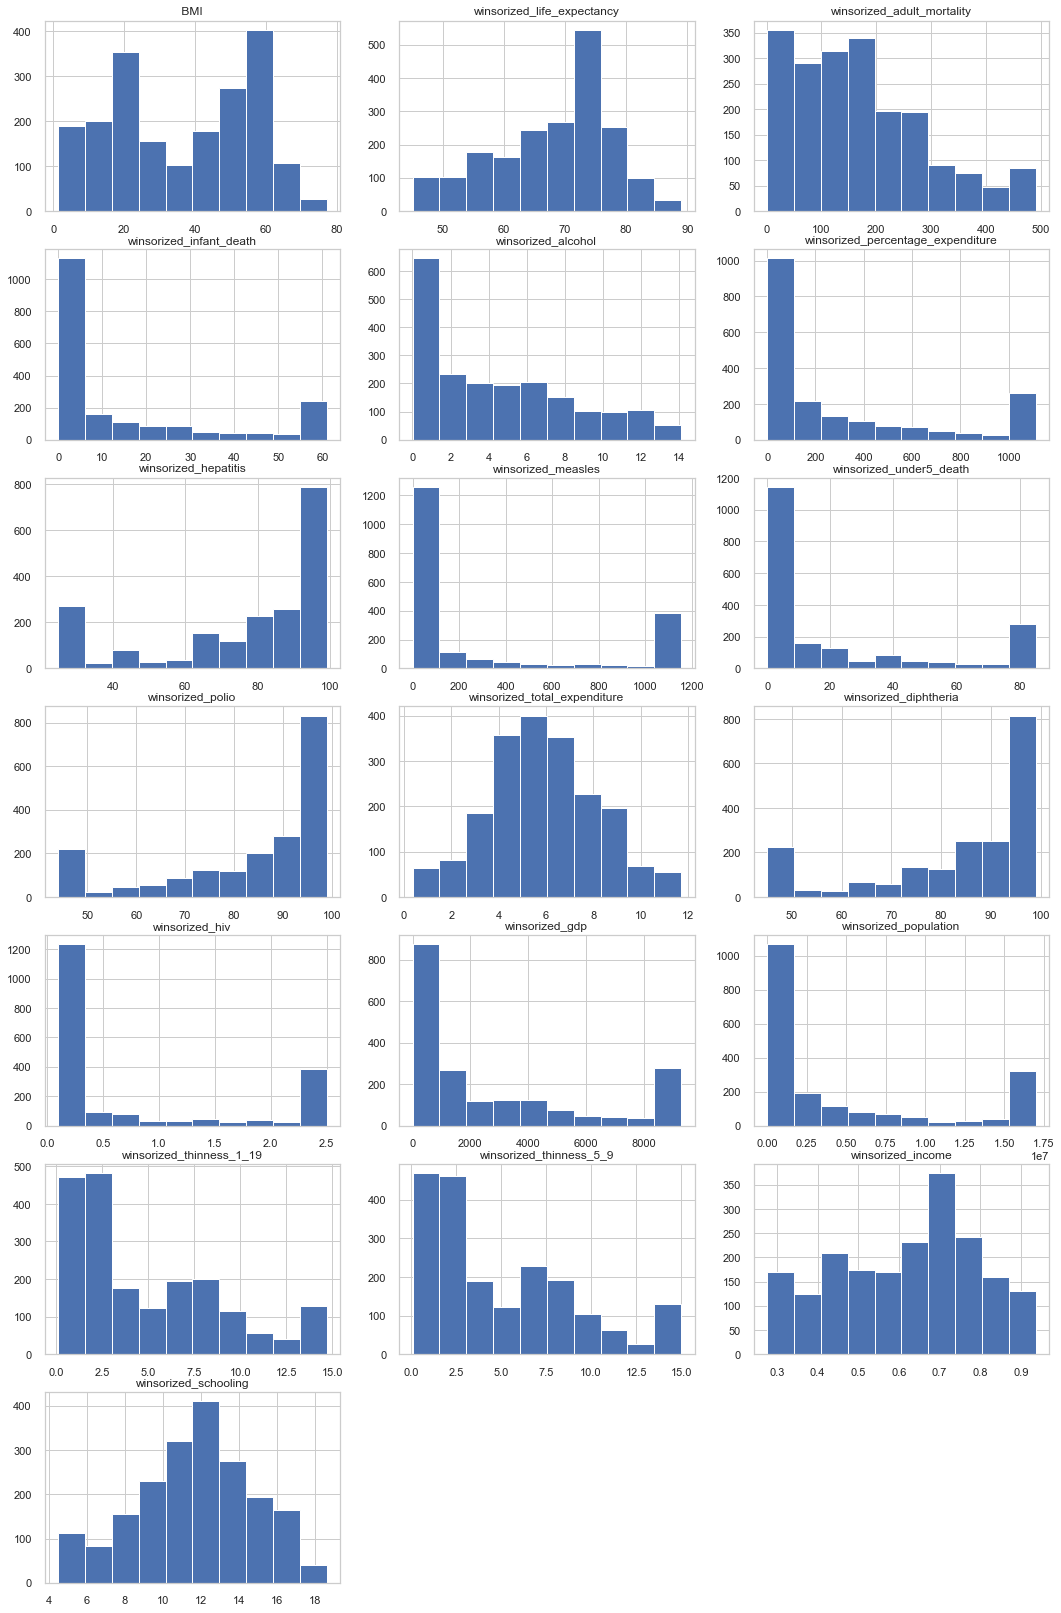

In [69]:
plt.figure(figsize =(18, 75))

for i in range(len(features)):
    plt.subplot(18, 3, i+1 )
    plt.hist(df[features[i]])
    plt.title(features[i])
    
plt.show()

winsorized_life_expectancy, winsorized_total_expenditure, and winsorized_schooling are close to normaly distribution.

## Multivariate Analysis

### Scatterplot

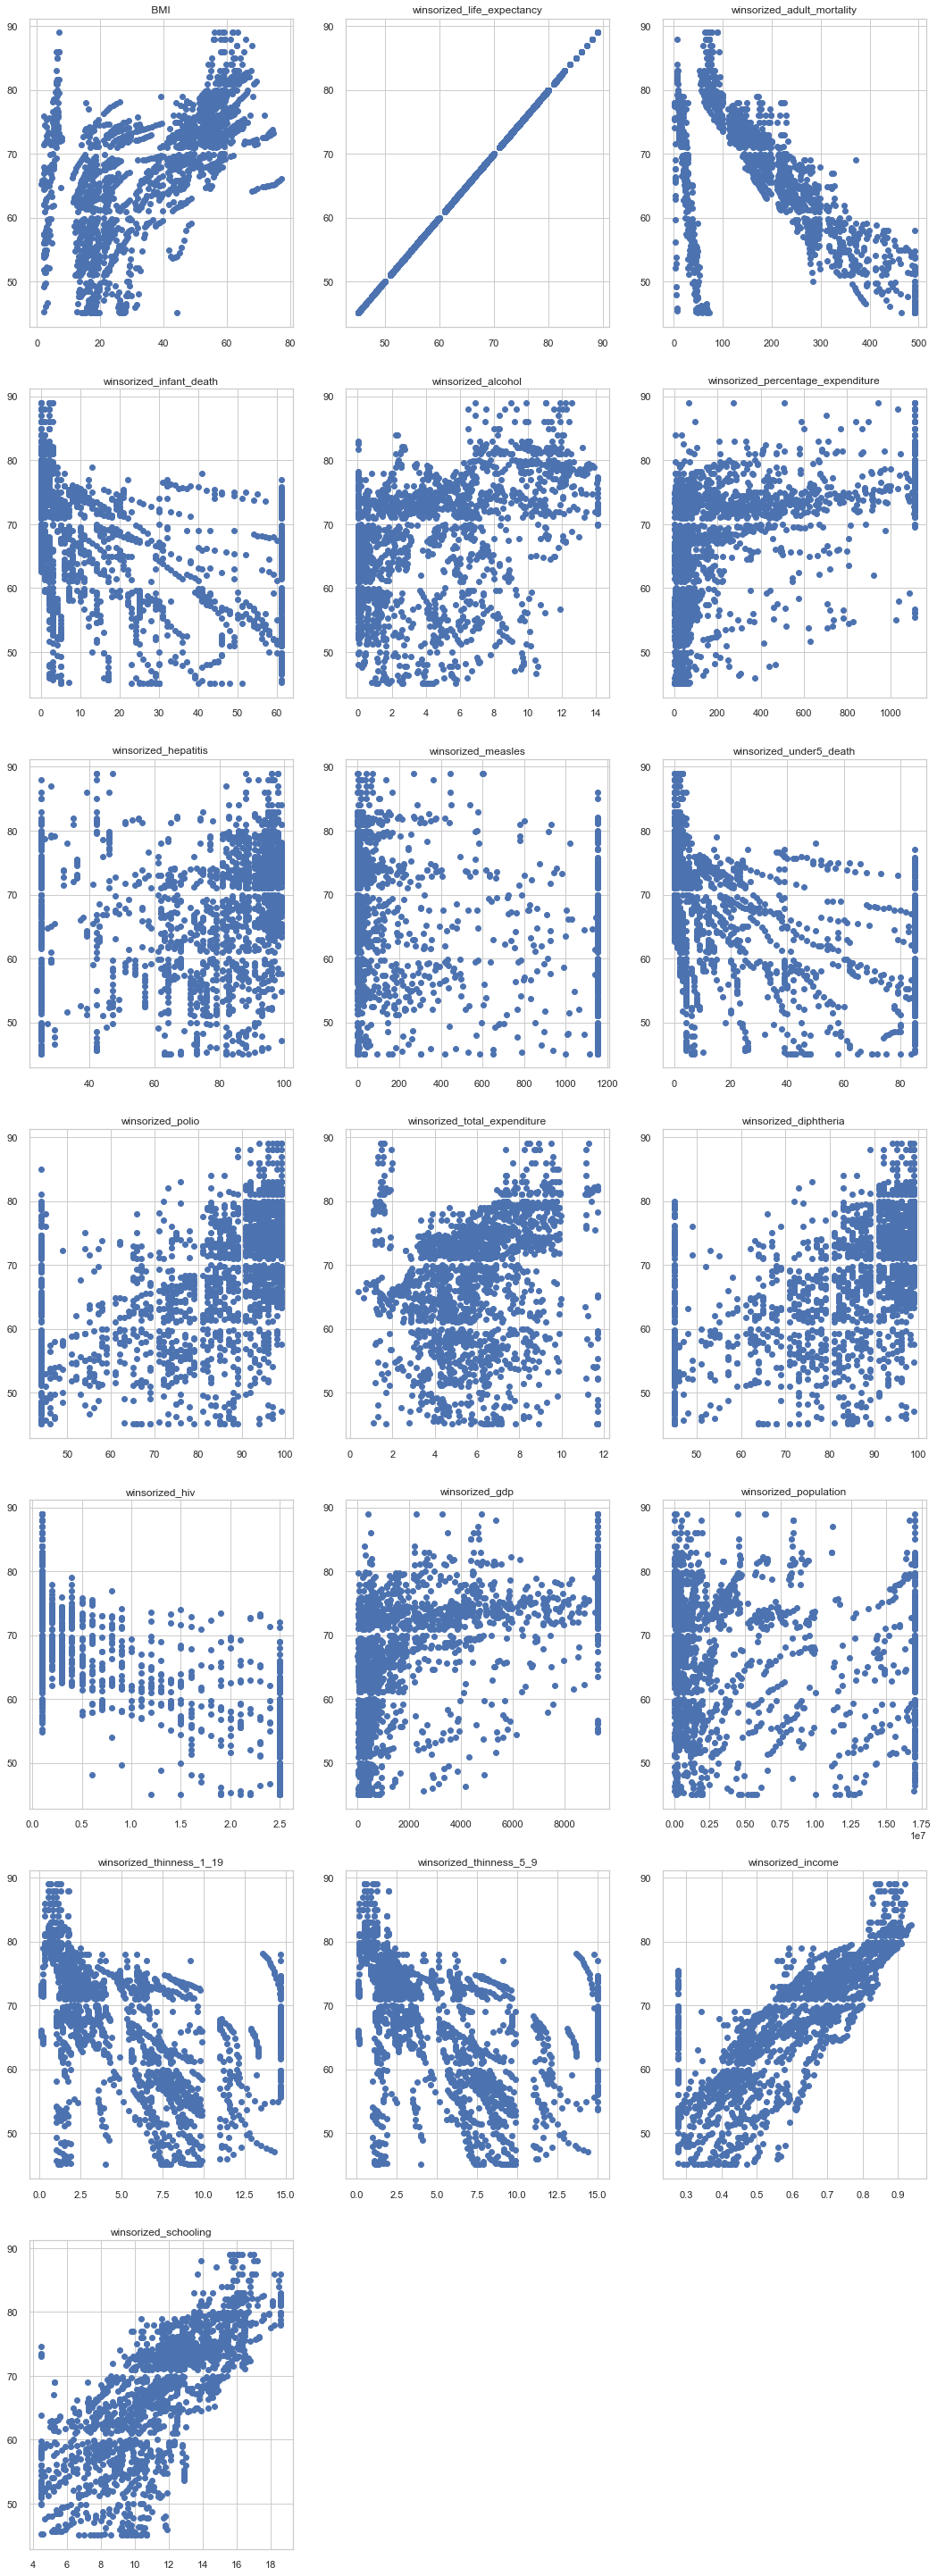

In [73]:
plt.figure(figsize = (18, 75))

for i in range(len(features)):
    plt.subplot(10, 3, i +1)
    plt.scatter(df[features[i]], y = df["winsorized_life_expectancy"])
    plt.title(features[i])
    
plt.show()

We see that life expectancy has positive relationships with BMI, income, and schooling. Also, it has a negative relationship with adult mortality and HIV.

### Correlation coefficient

In [77]:
df[features].corr()

,BMI,winsorized_life_expectancy,winsorized_adult_mortality,winsorized_infant_death,winsorized_alcohol,winsorized_percentage_expenditure,winsorized_hepatitis,winsorized_measles,winsorized_under5_death,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hiv,winsorized_gdp,winsorized_population,winsorized_thinness_1_19,winsorized_thinness_5_9,winsorized_income,winsorized_schooling
BMI,1.000000,0.601434,-0.384986,-0.475304,0.380291,0.420946,0.214440,-0.320338,-0.495232,0.326339,0.236184,0.328345,-0.481283,0.435922,-0.067843,-0.596775,-0.605480,0.611216,0.600693
winsorized_life_expectancy,0.601434,1.000000,-0.654255,-0.516494,0.396073,0.557117,0.277594,-0.313013,-0.552035,0.516167,0.208400,0.535687,-0.800895,0.551722,-0.040138,-0.519268,-0.511774,0.823222,0.762333
winsorized_adult_mortality,-0.384986,-0.654255,1.000000,0.303275,-0.191173,-0.313519,-0.120834,0.162011,0.325745,-0.275361,-0.114441,-0.274879,0.572394,-0.307826,0.045473,0.338384,0.345448,-0.488595,-0.429127
winsorized_infant_death,-0.475304,-0.516494,0.303275,1.000000,-0.301196,-0.367645,-0.201863,0.585217,0.993583,-0.373281,-0.192206,-0.369402,0.368065,-0.355888,0.423702,0.411349,0.430696,-0.478552,-0.521371
winsorized_alcohol,0.380291,0.396073,-0.191173,-0.301196,1.000000,0.535143,0.117611,-0.172897,-0.304476,0.280870,0.232997,0.289133,-0.157256,0.539202,0.004264,-0.418899,-0.408302,0.590256,0.599497
winsorized_percentage_expenditure,0.420946,0.557117,-0.313519,-0.367645,0.535143,1.000000,0.104305,-0.228420,-0.375608,0.287148,0.287113,0.294386,-0.327375,0.915731,-0.027779,-0.396491,-0.396421,0.630088,0.613831
winsorized_hepatitis,0.214440,0.277594,-0.120834,-0.201863,0.117611,0.104305,1.000000,-0.219500,-0.214125,0.541327,0.135175,0.607466,-0.282203,0.137631,-0.059822,-0.160335,-0.170185,0.280198,0.293346
winsorized_measles,-0.320338,-0.313013,0.162011,0.585217,-0.172897,-0.228420,-0.219500,1.000000,0.581067,-0.273715,-0.175305,-0.275367,0.188101,-0.218882,0.290223,0.343537,0.349507,-0.274875,-0.336212
winsorized_under5_death,-0.495232,-0.552035,0.325745,0.993583,-0.304476,-0.375608,-0.214125,0.581067,1.000000,-0.394037,-0.187895,-0.391011,0.406649,-0.368849,0.403557,0.421799,0.437545,-0.509527,-0.549190
winsorized_polio,0.326339,0.516167,-0.275361,-0.373281,0.280870,0.287148,0.541327,-0.273715,-0.394037,1.000000,0.184363,0.835268,-0.432513,0.313125,-0.043777,-0.273410,-0.269335,0.521442,0.528211


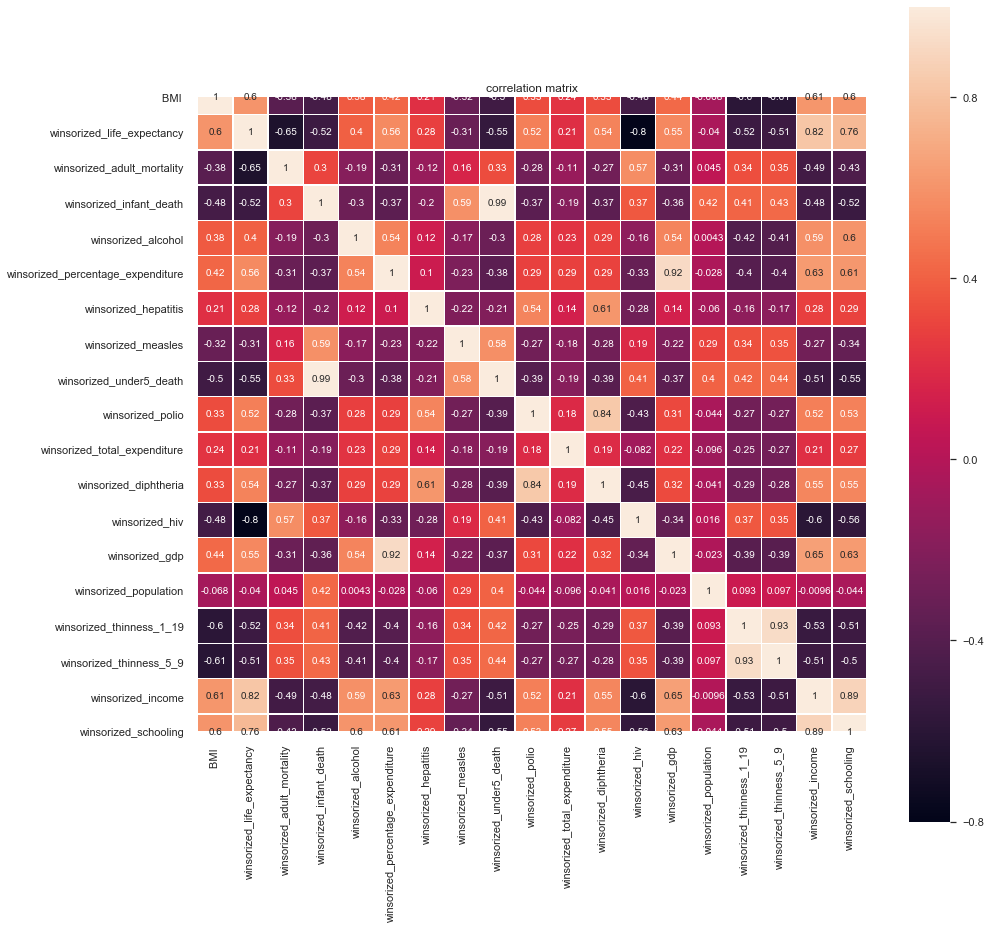

In [84]:
plt.figure(figsize = (15,15))
sns.heatmap(df[features].corr(), square=True, annot=True, linewidth=.5)
plt.title("correlation matrix")
plt.show()

With the correlation coefficient, we can also see that life expectancy has positive relationships with BMI, income, and schooling, and it has a negative relationship with adult mortality and HIV. Also, schooling and income have a positive relationship.

## Bivariate analysis of two categorical variables

In [86]:
df[["Status", "winsorized_life_expectancy"]].groupby(["Status"]).mean()

,winsorized_life_expectancy
Status,
Developed,78.831579
Developing,66.187368


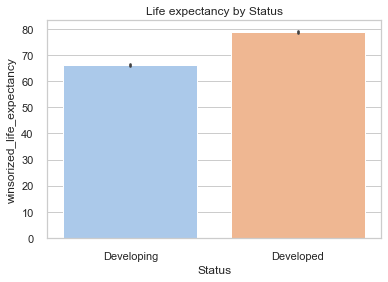

In [94]:
ax = sns.barplot(x="Status", y="winsorized_life_expectancy", data=df, palette="pastel")
plt.title("Life expectancy by Status")

plt.show()

Developed countries have higher life expectancy than developing countries.

## Bivariate analysis of a continuous-categorical pair

Text(0.5, 1.0, 'Life expectancy by Year')

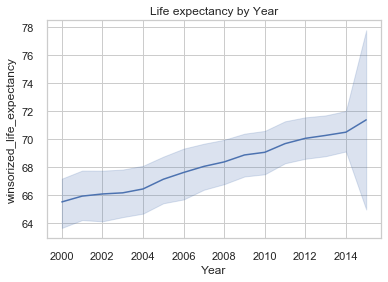

In [95]:
ax = sns.lineplot(x="Year", y="winsorized_life_expectancy", data=df)
plt.title("Life expectancy by Year")

Life expectancy increases over the years.

# 3. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

I'll only use life expectancy, BMI, income, scooling, adult mortality and HIV. 

In [139]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(np.log(df["winsorized_life_expectancy"]))
norm_stats = normaltest(np.log(df["winsorized_life_expectancy"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(df[" BMI "]))
norm_stats = normaltest(np.log(df[" BMI "]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(df["winsorized_income"]))
norm_stats = normaltest(np.log(df["winsorized_income"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

b_stats = jarque_bera(np.log(df["winsorized_schooling"]))
norm_stats = normaltest(np.log(df["winsorized_schooling"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(df["winsorized_adult_mortality"]))
norm_stats = normaltest(np.log(df["winsorized_adult_mortality"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(np.log(df["winsorized_hiv"]))
norm_stats = normaltest(np.log(df["winsorized_hiv"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 210.70454354754887 and p value is 0.0
Normality test statistics is 166.79192810201076 and p value is 6.047738435081817e-37
Jarque-Bera test statistics is 687.6932276761952 and p value is 0.0
Normality test statistics is 398.1048804299025 and p value is 3.569633307502539e-87
Jarque-Bera test statistics is 217.6053458679597 and p value is 0.0
Normality test statistics is 173.3338856147844 and p value is 2.29628069839105e-38
Jarque-Bera test statistics is 217.6053458679597 and p value is 0.0
Normality test statistics is 287.98434707918483 and p value is 2.9173839845755225e-63
Jarque-Bera test statistics is 876.9944154506793 and p value is 0.0
Normality test statistics is 445.7207357272346 and p value is 1.6329466716906235e-97
Jarque-Bera test statistics is 284.2994514346599 and p value is 0.0
Normality test statistics is 39493.10612992882 and p value is 0.0


Text(0.5, 1.0, 'histogram of HIV (BoxCox transformed)')

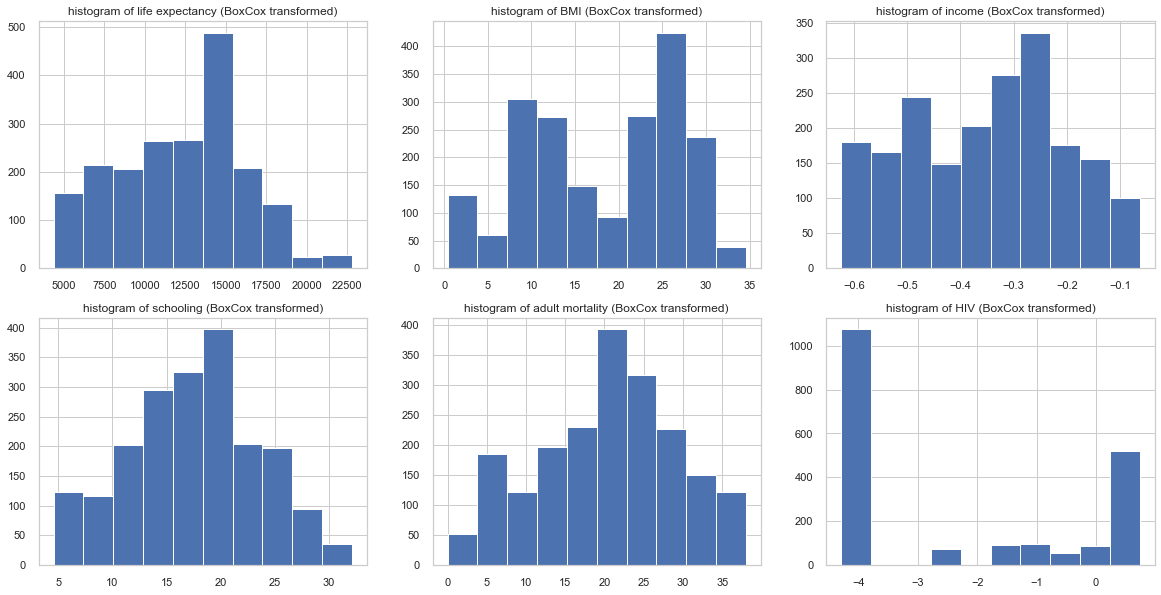

In [140]:
from scipy.stats import boxcox

life_expectancy_boxcox,_ = boxcox(df["winsorized_life_expectancy"])
bmi_boxcox,_ = boxcox(df[" BMI "])
income_boxcox,_ = boxcox(df["winsorized_income"])
schooling_boxcox,_ = boxcox(df["winsorized_schooling"])
adult_mortality_boxcox,_ = boxcox(df["winsorized_adult_mortality"])
hiv_boxcox,_ = boxcox(df["winsorized_hiv"])

plt.figure(figsize=(20,10))

plt.subplot(2,3,1)
plt.hist(life_expectancy_boxcox)
plt.title("histogram of life expectancy (BoxCox transformed)")

plt.subplot(2,3,2)
plt.hist(bmi_boxcox)
plt.title("histogram of BMI (BoxCox transformed)")

plt.subplot(2,3,3)
plt.hist(income_boxcox)
plt.title("histogram of income (BoxCox transformed)")

plt.subplot(2,3,4)
plt.hist(schooling_boxcox)
plt.title("histogram of schooling (BoxCox transformed)")

plt.subplot(2,3,5)
plt.hist(adult_mortality_boxcox)
plt.title("histogram of adult mortality (BoxCox transformed)")


plt.subplot(2,3,6)
plt.hist(hiv_boxcox)
plt.title("histogram of HIV (BoxCox transformed)")


In [142]:
# in case, one-hot encoding the Status variable: 
df = pd.concat([df, pd.get_dummies(df["Status"])], axis =1)
df

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Developing,life_expectancy_boxcox,bmi_boxcox,hiv_boxcox,adult_mortality_boxcox,income_boxcox,Developed,Developing,Developed,Developing
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,1,10615.227392,11.091542,-4.287583,27.711545,-0.472968,0,1,0,1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,1,8700.802103,10.843572,-4.287583,28.139870,-0.475361,0,1,0,1
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,1,8700.802103,10.594005,-4.287583,27.980034,-0.480135,0,1,0,1
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,1,8560.063993,10.342785,-4.287583,28.192942,-0.485680,0,1,0,1
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,1,8455.396589,10.140580,-4.287583,28.351548,-0.492772,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,1,4360.890474,14.876633,0.737048,38.029196,-0.529099,0,1,0,1
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,1,4360.890474,14.694410,0.737048,38.029196,-0.520707,0,1,0,1
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,1,4360.890474,14.511534,0.737048,14.095093,-0.513790,0,1,0,1
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,1,4408.110878,14.327992,0.737048,38.029196,-0.513790,0,1,0,1


In [151]:
df['life_expectancy_boxcox'] = life_expectancy_boxcox
df['bmi_boxcox'] = bmi_boxcox
df['hiv_boxcox'] = hiv_boxcox
df['adult_mortality_boxcox'] = adult_mortality_boxcox
df['income_boxcox'] = income_boxcox
df['schooling_boxcox'] = schooling_boxcox

features_boxcox = ["life_expectancy_boxcox", "bmi_boxcox", "hiv_boxcox", "adult_mortality_boxcox", "income_boxcox", "schooling_boxcox"]

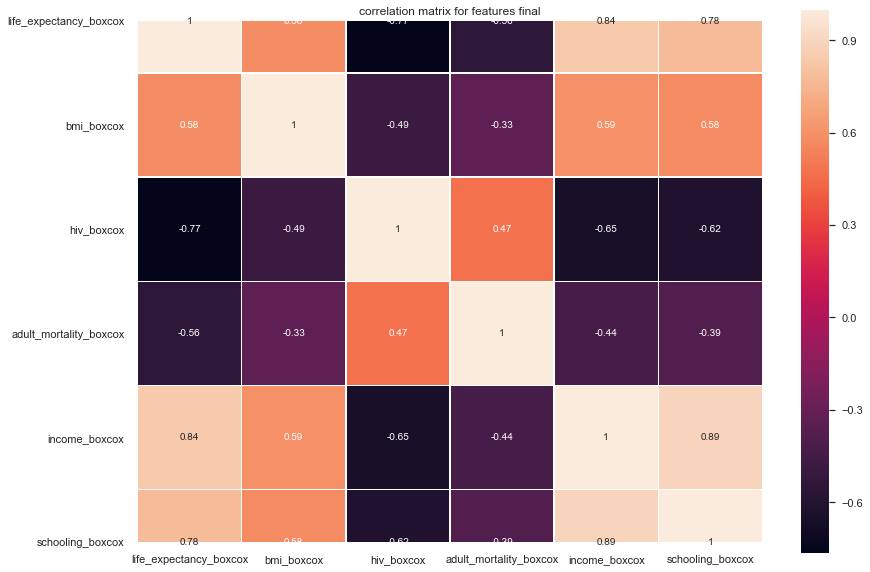

In [152]:
plt.figure(figsize=(14,10))
sns.heatmap(df[features_boxcox].corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix for features final")
plt.show()

Income has a stronger relationship than schooling with life expectancy. Therefore, we can drop the schooling feature.

# 4. Summarize your findings. One of the most important skills of a data scientist is to convey ideas and findings to nontechnical people using understandable language. In this regard, one of the most effective ways to communicate your ideas is to do it using effective visualization.

After all the work, we found that income has the most substantial positive relationship with life expectancy. Also, Status has a positive relationship. On the other hand, HIV has the strongest negative relationship. 